In [5]:
"""
Enhanced AI Text Detection Pipeline
-----------------------------------
核心改进:
1. 更好的LLM选择（T5/GPT-2用于重写）
2. 多维度特征提取
3. 更智能的扰动策略
4. 集成学习方法


"""


# 尝试导入，如果失败则提示安装

import os
import json
import hashlib
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
from tqdm import tqdm
import random
import pickle

# OpenAI library imports
import openai  # Good for catching error types like openai.RateLimitError
from openai import OpenAI  # ✅ **This is the missing line you need to add.**
import tiktoken

# 基础库
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import torch


from __future__ import annotations
import os, time, hashlib, json, random
from typing import List, Tuple

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
# Transformers
from transformers import (
        T5ForConditionalGeneration, T5Tokenizer,
        GPT2LMHeadModel, GPT2Tokenizer,
        AutoTokenizer, AutoModel
    )
from sentence_transformers import SentenceTransformer
# 文本处理
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# 文本扰动库
try:
    import nlpaug.augmenter.word as naw
    import nlpaug.augmenter.sentence as nas
except ImportError:
    print("nlpaug not found, installing...")
    os.system("pip install nlpaug")
    import nlpaug.augmenter.word as naw
    import nlpaug.augmenter.sentence as nas

# Transformers 和 sentence-transformers

from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, GPT2LMHeadModel, GPT2Tokenizer
from sentence_transformers import SentenceTransformer
from dataclasses import dataclass, field
from typing import List, Optional
# NLTK数据下载
try:
    import nltk
    print("Downloading required NLTK data...")
    nltk.download('punkt', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('averaged_perceptron_tagger_eng', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("NLTK data download completed.")
except Exception as e:
    print(f"NLTK download warning: {e}")
    print("Some augmentation features may not work properly.")
@dataclass
class DetectionConfig:
    """检测配置类"""
    # 模型选择
    revision_model: str = "t5-small"
    embedding_model: str = "all-MiniLM-L6-v2"
    
    # 【修正】为OpenAI API添加配置字段
    api_key: Optional[str] = None
    base_url: Optional[str] = None
    
    # 扰动参数
    perturbation_rate: float = 0.15
    # 【修正】使用field(default_factory=...)来避免可变默认参数问题
    perturbation_methods: List[str] = field(default_factory=lambda: ["synonym", "contextual"])
    
    # 检测参数
    similarity_threshold: float = 0.95 # 建议使用0.85作为更稳健的默认值
    use_ml_classifier: bool = True
    
    # 批处理
    batch_size: int = 16
    max_length: int = 512


    def __post_init__(self):
        if self.perturbation_methods is None:
            self.perturbation_methods = ["synonym", "contextual", "backtranslation"]

class EnhancedTextPerturber:
    """增强的文本扰动器"""

    def __init__(self, config: DetectionConfig):
        self.config = config
        self._init_augmenters()

    def _init_augmenters(self):
        """初始化各种扰动器"""
        self.augmenters = {
            "synonym": naw.SynonymAug(aug_src='wordnet', aug_p=self.config.perturbation_rate),
            "contextual": naw.ContextualWordEmbsAug(
                model_path='distilbert-base-uncased',
                action="substitute",
                aug_p=self.config.perturbation_rate
            ),
            "random_swap": naw.RandomWordAug(action="swap", aug_p=self.config.perturbation_rate),
            "spelling": naw.SpellingAug(aug_p=self.config.perturbation_rate),
        }

    def perturb(self, text: str, method: Optional[str] = None) -> str:
        """
        智能扰动策略

        Args:
            text: 原始文本
            method: 指定方法，None则随机选择
        Returns:
            扰动后的文本
        """
        if method is None:
            method = np.random.choice(self.config.perturbation_methods)

        try:
            if method == "backtranslation":
                return self._backtranslate(text)
            elif method in self.augmenters:
                augmented = self.augmenters[method].augment(text)
                return augmented[0] if isinstance(augmented, list) else augmented
            else:
                # 混合扰动
                return self._mixed_perturbation(text)
        except Exception as e:
            print(f"Perturbation failed: {e}")
            return self._simple_perturb(text)

    def _mixed_perturbation(self, text: str) -> str:
        """混合多种扰动方法"""
        sentences = sent_tokenize(text)
        perturbed_sentences = []

        for sent in sentences:
            # 随机选择扰动方法
            method = np.random.choice(list(self.augmenters.keys()))
            try:
                perturbed = self.augmenters[method].augment(sent)
                perturbed_sent = perturbed[0] if isinstance(perturbed, list) else perturbed
                perturbed_sentences.append(perturbed_sent)
            except:
                perturbed_sentences.append(sent)

        return ' '.join(perturbed_sentences)

    def _simple_perturb(self, text: str) -> str:
        """简单扰动作为后备"""
        words = text.split()

        # 随机替换15%的词
        num_changes = max(1, int(len(words) * self.config.perturbation_rate))
        indices = np.random.choice(range(len(words)), size=min(num_changes, len(words)), replace=False)

        for idx in indices:
            # 简单的字符级修改
            word = words[idx]
            if len(word) > 3:
                words[idx] = word[:-1] + np.random.choice(list('aeiou'))

        return ' '.join(words)

    def _backtranslate(self, text: str) -> str:
        """反向翻译（需要翻译API）"""
        # 这里只是示例，实际需要调用翻译API
        return text

class EnhancedLLMReviser:
    """增强的LLM重写器"""

    def __init__(self, config: DetectionConfig):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.client = None 
        self.model = None 
        self.tokenizer = None 
        self._init_reviser()

    def _init_model(self):
        """初始化重写模型"""
        model_name = self.config.revision_model

        if self.config.revision_model.startswith("t5"):
            # T5模型更适合文本重写任务
            self.tokenizer = T5Tokenizer.from_pretrained(self.config.revision_model)
            self.model = T5ForConditionalGeneration.from_pretrained(self.config.revision_model)
        elif self.config.revision_model == "gpt2":
            # GPT-2作为备选
            self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
            self.model = GPT2LMHeadModel.from_pretrained("gpt2")
            self.tokenizer.pad_token = self.tokenizer.eos_token
        elif model_name.startswith("gpt-"):
            # 【整合】初始化OpenAI API客户端
            api_key = self.config.api_key or os.getenv("OPENAI_API_KEY")
            if not api_key:
                raise ValueError("请在DetectionConfig中提供api_key或设置OPENAI_API_KEY环境变量")
            
            self.client = OpenAI(api_key=api_key, base_url=self.config.base_url)
            self.max_retries = 3
            self.retry_delay = 1.0
            print(f"OpenAI client initialized for model: {model_name}")
            if self.config.base_url:
                print(f"Using custom base URL: {self.config.base_url}")
        else:
            print(f"Warning: Unknown revision model '{model_name}'. Will use rule-based fallback.")


        self.model.to(self.device)
        self.model.eval()

    def _init_reviser(self):
        """根据配置初始化重写模型或API客户端"""
        model_name = self.config.revision_model
        
        if model_name.startswith("t5"):
            self.tokenizer = T5Tokenizer.from_pretrained(model_name)
            self.model = T5ForConditionalGeneration.from_pretrained(model_name)
            self.model.to(self.device).eval()
            print(f"Local T5 model loaded: {model_name}")
            
        elif model_name == "gpt2":
            self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
            self.model = GPT2LMHeadModel.from_pretrained(model_name)
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.model.to(self.device).eval()
            print(f"Local GPT-2 model loaded: {model_name}")

        elif model_name.startswith("gpt-"):
            # 【整合】初始化OpenAI API客户端
            api_key = self.config.api_key or os.getenv("OPENAI_API_KEY")
            if not api_key:
                raise ValueError("请在DetectionConfig中提供api_key或设置OPENAI_API_KEY环境变量")
            
            self.client = OpenAI(api_key=api_key, base_url=self.config.base_url)
            self.max_retries = 3
            self.retry_delay = 1.0
            print(f"OpenAI client initialized for model: {model_name}")
            if self.config.base_url:
                print(f"Using custom base URL: {self.config.base_url}")
        else:
            print(f"Warning: Unknown revision model '{model_name}'. Will use rule-based fallback.")

    
    def revise(self, text: str, cache: Dict[str, str]) -> str:
        """
        使用LLM重写文本
        
        Args:
            text: 待重写文本
            cache: 缓存字典
        Returns:
            重写后的文本
        """
        # 生成缓存键
        cache_key = hashlib.md5(f"{text}_{self.config.revision_model}".encode()).hexdigest()
        # print(f"\norigin text: {text}")
        if cache_key in cache:
            return cache[cache_key]
        
        try:
            model_name = self.config.revision_model
            revised = ""
            if model_name.startswith("t5"):
                revised = self._revise_with_t5(text)
                print(f"t5 rewrite: {revised}")
            elif model_name == "gpt2":
                revised = self._revise_with_gpt2(text)
                # print(f"gpt2 rewrite: {revised}")
            elif model_name.startswith("gpt-"):
                #api rewrite
                revised = self._revise_with_api(text)
                # print(f"gpt3.5 rewrite: {revised}")
            else:
                revised = self._rule_based_revision(text)
            
            cache[cache_key] = revised
            return revised
            
        except Exception as e:
            print(f"Revision failed with model {self.config.revision_model}: {e}")
            revised = self._rule_based_revision(text)
            cache[cache_key] = revised
            return revised

    def _revise_with_t5(self, text: str) -> str:
        """使用T5模型重写 - 优化版"""
        # T5需要特定的提示格式
        prompt = f"paraphrase: {text}"
    
        inputs = self.tokenizer.encode(
            prompt,
            return_tensors="pt",
            max_length=512,  # 对输入进行截断的最大长度
            truncation=True
        ).to(self.device)
    
        with torch.no_grad():
            # 使用束搜索 (Beam Search) 以获得更高质量和更稳定的输出
            outputs = self.model.generate(
                inputs,
                # --- 解码策略修改 ---
                num_beams=4,              # 修改：设置束的宽度，4或5是常用值
                early_stopping=True,      # 新增：当所有束都完成时提前停止
    
                # --- 长度控制优化 ---
                max_length=256,           # 修改：为输出设置一个固定的最大长度
                min_length=40,            # 新增：设置一个合理的最小长度，防止输出过短
    
                # --- 质量优化 ---
                repetition_penalty=1.2    # 新增：轻微惩罚重复，提升多样性
            )
            
            # 注意：使用 beam search 时，不需要 do_sample, temperature, top_p
    
        revised = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return revised

    # In class EnhancedLLMReviser
    def _revise_with_api(self, text: str) -> str:
        """Use OpenAI API with better prompting strategy"""
        if not self.client:
            raise ValueError("OpenAI client not initialized.")
        
        # Better prompt that encourages standardization
        system_prompt = """You are a professional editor. Your task is to rewrite the given text to make it more formal, standardized, and academic in style. 

Key guidelines:
- Replace casual expressions with formal language
- Use precise technical terms where appropriate
- Maintain professional tone throughout
- Standardize sentence structure
- Remove colloquialisms and personal expressions
- Keep the core meaning but express it in a more refined way

The more casual or informal the original text, the more changes you should make."""
        
        user_prompt = f"Please rewrite this text in a formal, academic style:\n\n{text}"
        
        for attempt in range(self.max_retries):
            try:
                response = self.client.chat.completions.create(
                    model=self.config.revision_model,
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_prompt}
                    ],
                    temperature=0.3,  # Lower temperature for more consistent output
                    top_p=0.9
                )
                return response.choices[0].message.content.strip()
                
            except Exception as e:
                print(f"API error (attempt {attempt + 1}): {e}")
                if attempt < self.max_retries - 1:
                    time.sleep(self.retry_delay)
                else:
                    return text
        
        return text
    

    

    def _rule_based_revision(self, text: str) -> str:
        """基于规则的重写"""
        import re

        # 句子重排
        sentences = sent_tokenize(text)
        if len(sentences) > 2:
            # 随机调整句子顺序（保持逻辑性）
            sentences = self._reorder_sentences(sentences)

        # 同义词替换
        revised_sentences = []
        for sent in sentences:
            # 简单的同义词映射
            synonyms = {
                "important": "significant",
                "however": "nevertheless",
                "therefore": "thus",
                "because": "since",
                "many": "numerous",
                "show": "demonstrate"
            }

            for word, syn in synonyms.items():
                sent = re.sub(r'\b' + word + r'\b', syn, sent, flags=re.IGNORECASE)

            revised_sentences.append(sent)

        return ' '.join(revised_sentences)

    def _reorder_sentences(self, sentences: List[str]) -> List[str]:
        """智能句子重排"""
        # 保持第一句和最后一句
        if len(sentences) <= 2:
            return sentences

        first = sentences[0]
        last = sentences[-1]
        middle = sentences[1:-1]

        # 打乱中间句子
        np.random.shuffle(middle)

        return [first] + middle + [last]

class MultiFeatureExtractor:
    """多维度特征提取器"""

    def __init__(self, config: DetectionConfig):
        self.config = config
        self.sentence_model = SentenceTransformer(config.embedding_model)
        self._init_linguistic_features()

    def _init_linguistic_features(self):
        """初始化语言学特征提取"""
        try:
            nltk.download('punkt', quiet=True)
            nltk.download('averaged_perceptron_tagger', quiet=True)
            nltk.download('stopwords', quiet=True)
            self.stop_words = set(stopwords.words('english'))
        except:
            self.stop_words = set()

    def extract_features(self, original: str, revised: str) -> Dict[str, float]:
        """
        提取多维度特征

        Returns:
            特征字典
        """
        features = {}

        # 1. 语义相似度
        features['semantic_similarity'] = self._compute_semantic_similarity(original, revised)

        # 2. 词汇级特征
        features.update(self._extract_lexical_features(original, revised))

        # 3. 句法特征
        features.update(self._extract_syntactic_features(original, revised))

        # 4. 风格特征
        features.update(self._extract_stylistic_features(original, revised))

        # 5. 编辑距离特征
        features.update(self._extract_edit_features(original, revised))

        return features

    def _compute_semantic_similarity(self, text1: str, text2: str) -> float:
        """计算语义相似度"""
        emb1 = self.sentence_model.encode(text1)
        emb2 = self.sentence_model.encode(text2)

        from sklearn.metrics.pairwise import cosine_similarity
        return float(cosine_similarity([emb1], [emb2])[0, 0])

    def _extract_lexical_features(self, original: str, revised: str) -> Dict[str, float]:
        """提取词汇级特征"""
        orig_words = set(word_tokenize(original.lower()))
        rev_words = set(word_tokenize(revised.lower()))

        # 词汇重叠率
        overlap = len(orig_words & rev_words)
        total = len(orig_words | rev_words)

        features = {
            'word_overlap_ratio': overlap / total if total > 0 else 0,
            'vocabulary_change_ratio': len(orig_words ^ rev_words) / total if total > 0 else 0,
            'unique_words_ratio': len(rev_words - orig_words) / len(rev_words) if rev_words else 0
        }

        # 停用词比例变化
        orig_stop = len([w for w in orig_words if w in self.stop_words])
        rev_stop = len([w for w in rev_words if w in self.stop_words])

        features['stopword_ratio_change'] = abs(
            (orig_stop / len(orig_words) if orig_words else 0) -
            (rev_stop / len(rev_words) if rev_words else 0)
        )

        return features

    def _extract_syntactic_features(self, original: str, revised: str) -> Dict[str, float]:
        """提取句法特征"""
        orig_sents = sent_tokenize(original)
        rev_sents = sent_tokenize(revised)

        features = {
            'sentence_count_ratio': len(rev_sents) / len(orig_sents) if orig_sents else 1,
            'avg_sentence_length_change': abs(
                np.mean([len(word_tokenize(s)) for s in orig_sents]) -
                np.mean([len(word_tokenize(s)) for s in rev_sents])
            ) if orig_sents and rev_sents else 0
        }

        # POS标签分布变化
        try:
            orig_pos = nltk.pos_tag(word_tokenize(original))
            rev_pos = nltk.pos_tag(word_tokenize(revised))

            # 计算主要词性比例变化
            for pos_type in ['NN', 'VB', 'JJ', 'RB']:  # 名词、动词、形容词、副词
                orig_count = sum(1 for _, pos in orig_pos if pos.startswith(pos_type))
                rev_count = sum(1 for _, pos in rev_pos if pos.startswith(pos_type))

                features[f'pos_{pos_type}_ratio_change'] = abs(
                    (orig_count / len(orig_pos) if orig_pos else 0) -
                    (rev_count / len(rev_pos) if rev_pos else 0)
                )
        except:
            pass

        return features

    def _extract_stylistic_features(self, original: str, revised: str) -> Dict[str, float]:
        """提取风格特征"""
        features = {}

        # 标点符号使用变化
        orig_punct = sum(1 for c in original if c in '.,!?;:')
        rev_punct = sum(1 for c in revised if c in '.,!?;:')

        features['punctuation_ratio_change'] = abs(
            (orig_punct / len(original) if original else 0) -
            (rev_punct / len(revised) if revised else 0)
        )

        # 大写字母比例变化
        orig_caps = sum(1 for c in original if c.isupper())
        rev_caps = sum(1 for c in revised if c.isupper())

        features['capitalization_ratio_change'] = abs(
            (orig_caps / len(original) if original else 0) -
            (rev_caps / len(revised) if revised else 0)
        )

        # 平均词长变化
        orig_words = word_tokenize(original)
        rev_words = word_tokenize(revised)

        features['avg_word_length_change'] = abs(
            np.mean([len(w) for w in orig_words]) -
            np.mean([len(w) for w in rev_words])
        ) if orig_words and rev_words else 0

        return features

    def _extract_edit_features(self, original: str, revised: str) -> Dict[str, float]:
        """提取编辑距离相关特征"""
        from difflib import SequenceMatcher

        # 字符级相似度
        char_similarity = SequenceMatcher(None, original, revised).ratio()

        # 词级相似度
        orig_words = word_tokenize(original)
        rev_words = word_tokenize(revised)
        word_similarity = SequenceMatcher(None, orig_words, rev_words).ratio()

        features = {
            'char_level_similarity': char_similarity,
            'word_level_similarity': word_similarity,
            'length_ratio': len(revised) / len(original) if original else 1
        }

        return features

class AITextDetector:
    """主检测器类"""

    def __init__(self, config: DetectionConfig = None):
        self.config = config or DetectionConfig()
        self.perturber = EnhancedTextPerturber(self.config)
        self.reviser = EnhancedLLMReviser(self.config)
        self.feature_extractor = MultiFeatureExtractor(self.config)
        self.classifier = None
        self.scaler = StandardScaler()
        self.cache = {}

    def detect_batch(self, texts: List[str],
                     labels: Optional[List[int]] = None) -> Dict[str, np.ndarray]:
        """
        批量检测文本

        Args:
            texts: 文本列表
            labels: 真实标签（可选，用于训练）
        Returns:
            包含预测结果和特征的字典
        """
        all_features = []
        all_scores = []

        print("Processing texts...")
        for i, text in enumerate(tqdm(texts)):
            try:
                # 1. 扰动
                perturbed = self.perturber.perturb(text)

                # 2. LLM重写
                revised = self.reviser.revise(perturbed, self.cache)

                # 3. 特征提取
                features = self.feature_extractor.extract_features(text, revised)
                all_features.append(features)

                # 4. 主要相似度分数
                all_scores.append(features['semantic_similarity'])

            except Exception as e:
                print(f"Error processing text {i}: {e}")
                # 使用默认值
                default_features = {key: 0.5 for key in ['semantic_similarity', 'word_overlap_ratio',
                                                         'vocabulary_change_ratio', 'unique_words_ratio',
                                                         'stopword_ratio_change', 'sentence_count_ratio',
                                                         'avg_sentence_length_change', 'punctuation_ratio_change',
                                                         'capitalization_ratio_change', 'avg_word_length_change',
                                                         'char_level_similarity', 'word_level_similarity',
                                                         'length_ratio']}
                all_features.append(default_features)
                all_scores.append(0.5)

        # 转换为特征矩阵
        feature_matrix = pd.DataFrame(all_features).fillna(0).values

        # 如果使用ML分类器
        if self.config.use_ml_classifier:
            if labels is not None and self.classifier is None:
                # 训练分类器
                self._train_classifier(feature_matrix, labels)

            if self.classifier is not None:
                # 标准化特征
                feature_matrix_scaled = self.scaler.transform(feature_matrix)
                # 预测
                predictions = self.classifier.predict(feature_matrix_scaled)
                probabilities = self.classifier.predict_proba(feature_matrix_scaled)[:, 1]
            else:
                # 使用阈值方法
                predictions = (np.array(all_scores) > self.config.similarity_threshold).astype(int)
                probabilities = np.array(all_scores)
        else:
            # 仅使用阈值
            predictions = (np.array(all_scores) > self.config.similarity_threshold).astype(int)
            probabilities = np.array(all_scores)

        return {
            'predictions': predictions,
            'probabilities': probabilities,
            'features': feature_matrix,
            'similarity_scores': np.array(all_scores)
        }
    
    def _train_classifier(self, features: np.ndarray, labels: List[int]):
        """训练机器学习分类器"""
        print("Training classifier...")

        # 标准化特征
        features_scaled = self.scaler.fit_transform(features)

        # 使用随机森林
        self.classifier = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )

        self.classifier.fit(features_scaled, labels)

        # 特征重要性
        feature_names = list(pd.DataFrame(features).columns)
        importances = self.classifier.feature_importances_

        print("\nTop 10 Most Important Features:")
        for feat, imp in sorted(zip(feature_names, importances),
                               key=lambda x: x[1], reverse=True)[:10]:
            print(f"  {feat}: {imp:.4f}")

    def save_model(self, path: str):
        """保存模型"""
        import pickle

        model_data = {
            'classifier': self.classifier,
            'scaler': self.scaler,
            'config': self.config,
            'cache': self.cache
        }

        with open(path, 'wb') as f:
            pickle.dump(model_data, f)

        print(f"Model saved to {path}")

    def load_model(self, path: str):
        """加载模型"""
        import pickle

        with open(path, 'rb') as f:
            model_data = pickle.load(f)

        self.classifier = model_data['classifier']
        self.scaler = model_data['scaler']
        self.config = model_data['config']
        self.cache = model_data['cache']

        print(f"Model loaded from {path}")
        
        
# ------------------------------------------------------------
# 数据集加载函数（从骨架代码整合）
# ------------------------------------------------------------
def load_data(path: str) -> pd.DataFrame:
    """
    读取带有 'text' 与 'label' 列的数据集，并返回 DataFrame。
    支持金融数据集格式和通用格式。

    Args:
        path: 数据文件路径、'finance' 表示使用金融数据集、'sample' 表示创建示例数据
    Returns:
        df: columns = ['id', 'text', 'label']
    """
    if path == 'finance':
        return load_finance_dataset()
    elif path == 'sample':
        return create_sample_dataset()

    try:
        if path.endswith('.csv'):
            df = pd.read_csv(path)
        elif path.endswith('.jsonl'):
            df = pd.read_json(path, lines=True)
        elif path.endswith('.json'):
            df = pd.read_json(path)
        else:
            raise ValueError(f"Unsupported file format: {path}")

        # 确保有必要的列
        if 'text' not in df.columns:
            raise ValueError("Missing 'text' column in dataset")
        if 'label' not in df.columns:
            raise ValueError("Missing 'label' column in dataset")

        # 如果没有id列，自动生成
        if 'id' not in df.columns:
            df['id'] = range(len(df))

        # 数据清洗
        df = df.dropna(subset=['text', 'label'])
        df = df[df['text'].str.len() > 10]  # 过滤太短的文本

        print(f"Loaded {len(df)} samples from {path}")
        print(f"Label distribution: {df['label'].value_counts().to_dict()}")

        return df[['id', 'text', 'label']]

    except FileNotFoundError:
        print(f"File {path} not found. Creating sample dataset...")
        return create_sample_dataset()


def find_finance_data_files():
    """查找金融数据集文件"""
    print("Searching for finance data files...")

    # Kaggle环境路径
    possible_paths = [
        "/kaggle/input/finance-dataset",
        "/kaggle/input/finance-data",
        "/kaggle/input/human-chatgpt-finance",
        "/kaggle/input",
        "./data",  # 本地路径
        "."
    ]

    files_found = {}

    for path in possible_paths:
        if os.path.exists(path):
            print(f"Checking path: {path}")
            for root, dirs, files in os.walk(path):
                for file in files:
                    if 'revised_human_finance' in file or 'revised_human' in file:
                        files_found['revised_human'] = os.path.join(root, file)
                    elif 'revised_chatgpt_finance' in file or 'revised_chatgpt' in file:
                        files_found['revised_chatgpt'] = os.path.join(root, file)
                    elif 'finance.jsonl' in file:
                        files_found['original'] = os.path.join(root, file)

    return files_found
def load_finance_dataset() -> pd.DataFrame:
    """
    加载金融数据集 - 使用修订后的文本作为数据
    修复了多行JSON解析问题
    
    Returns:
        df: columns = ['id', 'text', 'label']
        其中text是修订后的文本，label: 0=human, 1=chatgpt
    """
    files = find_finance_data_files()
    
    print("Loading finance datasets...")
    print(f"Found files: {list(files.keys())}")
    
    all_texts = []
    all_labels = []
    
    # 1. 加载修订后的人类文本（每行一个JSON对象）
    if 'revised_human' in files:
        try:
            print(f"Loading revised human texts...")
            with open(files['revised_human'], 'r', encoding='utf-8') as f:
                for line_no, line in enumerate(f, 1):
                    line = line.strip()
                    if line:
                        try:
                            # 每行是一个独立的JSON对象
                            item = json.loads(line)
                            for idx, text in item.items():
                                # 清理文本
                                cleaned_text = text.strip().replace('\\n\\n', ' ').replace('\\n', ' ')
                                if len(cleaned_text) > 20:
                                    all_texts.append(cleaned_text)
                                    all_labels.append(0)  # 0 = human
                        except json.JSONDecodeError as e:
                            print(f"  Line {line_no} parse error: {e}")
            print(f"  Loaded {len([l for l in all_labels if l == 0])} human texts")
        except Exception as e:
            print(f"Error loading revised human texts: {e}")
    
    # 2. 加载修订后的ChatGPT文本（每行一个JSON对象）
    if 'revised_chatgpt' in files:
        try:
            print(f"Loading revised ChatGPT texts...")
            with open(files['revised_chatgpt'], 'r', encoding='utf-8') as f:
                for line_no, line in enumerate(f, 1):
                    line = line.strip()
                    if line:
                        try:
                            # 每行是一个独立的JSON对象
                            item = json.loads(line)
                            for idx, text in item.items():
                                # 清理文本
                                cleaned_text = text.strip().replace('\\n\\n', ' ').replace('\\n', ' ')
                                if len(cleaned_text) > 20:
                                    all_texts.append(cleaned_text)
                                    all_labels.append(1)  # 1 = chatgpt
                        except json.JSONDecodeError as e:
                            print(f"  Line {line_no} parse error: {e}")
            print(f"  Loaded {len([l for l in all_labels if l == 1])} ChatGPT texts")
        except Exception as e:
            print(f"Error loading revised ChatGPT texts: {e}")
    
    # 3. 如果没有数据，尝试原始文件或创建示例
    if len(all_texts) == 0:
        if 'original' in files:
            print("\nNo revised texts found. Loading from original finance.jsonl...")
            try:
                with open(files['original'], encoding="utf-8") as f:
                    for row in f:
                        if row.strip():
                            data = json.loads(row)
                            # 人类答案
                            human_answers = data.get("human_answers", [])
                            if human_answers and human_answers[0]:
                                all_texts.append(human_answers[0])
                                all_labels.append(0)
                            # ChatGPT答案
                            chatgpt_answers = data.get("chatgpt_answers", [])
                            if chatgpt_answers and chatgpt_answers[0]:
                                all_texts.append(chatgpt_answers[0])
                                all_labels.append(1)
                print(f"  Loaded {len(all_texts)} texts from original file")
            except Exception as e:
                print(f"Error loading original file: {e}")
        
        if len(all_texts) == 0:
            print("Creating sample dataset...")
            return create_sample_dataset()
    
    # 4. 创建DataFrame
    df = pd.DataFrame({
        'id': range(len(all_texts)),
        'text': all_texts,
        'label': all_labels
    })
    
    # 打乱数据
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df['id'] = range(len(df))
    
    print(f"\n=== Dataset Summary ===")
    print(f"Total samples: {len(df)}")
    print(f"Human texts: {len(df[df['label'] == 0])}")
    print(f"ChatGPT texts: {len(df[df['label'] == 1])}")
    
    # 显示示例
    if len(df) > 0:
        print("\nSample texts:")
        for label in [0, 1]:
            label_name = "Human" if label == 0 else "ChatGPT"
            samples = df[df['label'] == label]
            if len(samples) > 0:
                sample_text = samples.iloc[0]['text']
                print(f"\n[{label_name}]: {sample_text[:100]}...")
    
    return df[['id', 'text', 'label']]

def create_sample_dataset(n_samples: int = 100) -> pd.DataFrame:
    """创建示例数据集用于测试"""
    import random

    human_texts = [
        "I think artificial intelligence will revolutionize many industries in the coming decades.",
        "The weather today is quite pleasant, perfect for a walk in the park.",
        "Machine learning algorithms have shown remarkable progress in recent years.",
        "I love reading books, especially mystery novels and science fiction.",
        "Climate change is one of the most pressing issues facing humanity today.",
        "Just finished my morning coffee, feeling ready to tackle the day!",
        "My cat knocked over my plant again. Why do they always do that?",
        "Been trying to learn guitar but my fingers hurt so much. Is this normal?",
        "The new restaurant downtown is pretty good but a bit pricey for what you get.",
        "I can't believe how fast this year has gone by. Feels like January was yesterday."
    ] * (n_samples // 20)

    ai_texts = [
        "Artificial intelligence represents a paradigm shift in technological advancement, offering unprecedented opportunities for innovation across multiple sectors.",
        "The meteorological conditions today present optimal parameters for outdoor recreational activities.",
        "Contemporary machine learning methodologies demonstrate significant improvements in performance metrics.",
        "Literary consumption, particularly within the mystery and science fiction genres, provides considerable intellectual stimulation.",
        "Climate change constitutes a critical global challenge requiring immediate and comprehensive action.",
        "The implementation of blockchain technology has demonstrated substantial potential for revolutionizing financial systems.",
        "Quantum computing represents a fundamental breakthrough in computational capabilities with far-reaching implications.",
        "The integration of renewable energy sources is essential for achieving sustainable development goals.",
        "Advancements in biotechnology continue to push the boundaries of medical treatment possibilities.",
        "The digital transformation of industries necessitates comprehensive adaptation strategies for organizational success."
    ] * (n_samples // 20)

    texts = human_texts[:n_samples//2] + ai_texts[:n_samples//2]
    labels = [0] * (n_samples//2) + [1] * (n_samples//2)

    # 随机打乱
    combined = list(zip(texts, labels))
    random.shuffle(combined)
    texts, labels = zip(*combined)

    return pd.DataFrame({
        'id': range(len(texts)),
        'text': texts,
        'label': labels
    })





def evaluate_detector(detector: AITextDetector,
                     texts: List[str],
                     labels: List[int]) -> Dict[str, float]:
    """
    评估检测器性能
    """
    results = detector.detect_batch(texts, labels)

    predictions = results['predictions']
    probabilities = results['probabilities']

    # 计算指标
    metrics = {
        'accuracy': accuracy_score(labels, predictions),
        'auc': roc_auc_score(labels, probabilities),
    }

    print("\n=== Evaluation Results ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    print("\nClassification Report:")
    print(classification_report(labels, predictions,
                              target_names=['Human', 'AI']))

    # 分析相似度分布
    human_scores = results['similarity_scores'][np.array(labels) == 0]
    ai_scores = results['similarity_scores'][np.array(labels) == 1]

    print(f"\nSimilarity Score Distribution:")
    print(f"Human texts - Mean: {np.mean(human_scores):.3f}, Std: {np.std(human_scores):.3f}")
    print(f"AI texts - Mean: {np.mean(ai_scores):.3f}, Std: {np.std(ai_scores):.3f}")

    return metrics

# 主执行函数
def main(data_path: str = "finance",
         max_samples: Optional[int] = None,
         use_cache: bool = True,
         config: Optional[DetectionConfig] = None):
    """
    主执行函数 - 使用增强版检测器

    Args:
        data_path: 数据文件路径或 'finance'/'sample'
        max_samples: 限制处理的样本数量（用于快速测试）
        use_cache: 是否使用缓存
        config: 检测器配置
    """
    print("=== Enhanced AI Text Detection ===")
    print(f"Method: Multi-feature extraction with {config.revision_model if config else 'default model'}")
    
    # 1. 加载数据
    df = load_data(data_path)
    if max_samples:
        df = df.head(max_samples)
        print(f"Using first {max_samples} samples for testing")

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    texts = df['text'].tolist()
    labels = df['label'].tolist()

    # 2. 数据分割（70% 训练，30% 测试）
    split_idx = int(len(texts) * 0.4)
    train_texts, test_texts = texts[:split_idx], texts[split_idx:]
    train_labels, test_labels = labels[:split_idx], labels[split_idx:]

    print(f"\nDataset split: {len(train_texts)} training, {len(test_texts)} testing")

    # 3. 创建检测器
    if config is None:
        config = DetectionConfig(
            revision_model="t5-small",  # 或 "gpt2" t5-small
            embedding_model="all-MiniLM-L6-v2",
            perturbation_rate=0.15,
            use_ml_classifier=True
        )

    detector = AITextDetector(config)

    # 4. 加载缓存
    cache_path = f"enhanced_cache_{config.revision_model}.json"
    if use_cache and os.path.exists(cache_path):
        with open(cache_path, 'r') as f:
            detector.cache = json.load(f)
        print(f"Loaded cache with {len(detector.cache)} entries")

    # 5. 训练阶段
    print("\n=== Training Phase ===")
    print("Train labels distribution:",
      pd.Series(train_labels).value_counts().to_dict())
    train_results = detector.detect_batch(train_texts, train_labels)

    # 6. 测试阶段
    print("\n=== Testing Phase ===")
    test_results = detector.detect_batch(test_texts)

    # 7. 评估结果
    test_predictions = test_results['predictions']
    test_probabilities = test_results['probabilities']

    from sklearn.metrics import confusion_matrix

    # 计算指标
    accuracy = accuracy_score(test_labels, test_predictions)
    auc = roc_auc_score(test_labels, test_probabilities)

    print(f"\n=== Test Results ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")

    # 详细报告
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions,
                              target_names=['Human', 'AI']))

    # 混淆矩阵
    cm = confusion_matrix(test_labels, test_predictions)
    print("\nConfusion Matrix:")
    print(f"              Predicted")
    print(f"            Human    AI")
    print(f"Actual Human  {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"       AI     {cm[1,0]:4d}  {cm[1,1]:4d}")

    # 特征分析
    features_df = test_results['features']
    similarity_scores = test_results['similarity_scores']

    # 分组统计
    human_scores = similarity_scores[np.array(test_labels) == 0]
    ai_scores = similarity_scores[np.array(test_labels) == 1]

    print(f"\n=== Similarity Score Analysis ===")
    print(f"Human texts:")
    print(f"  Mean: {np.mean(human_scores):.3f}, Std: {np.std(human_scores):.3f}")
    print(f"  Min: {np.min(human_scores):.3f}, Max: {np.max(human_scores):.3f}")

    print(f"AI texts:")
    print(f"  Mean: {np.mean(ai_scores):.3f}, Std: {np.std(ai_scores):.3f}")
    print(f"  Min: {np.min(ai_scores):.3f}, Max: {np.max(ai_scores):.3f}")

    # 显示错误分类的例子
    print("\n=== Misclassified Examples ===")
    misclassified_idx = np.where(test_predictions != test_labels)[0]

    for i, idx in enumerate(misclassified_idx[:50]):  # 显示前5个
        true_label = "AI" if test_labels[idx] == 1 else "Human"
        pred_label = "AI" if test_predictions[idx] == 1 else "Human"
        text = test_texts[idx][:100] + "..." if len(test_texts[idx]) > 100 else test_texts[idx]

        print(f"\nExample {i+1}:")
        print(f"Text: {text}")
        print(f"True: {true_label}, Predicted: {pred_label}")
        print(f"Similarity: {similarity_scores[idx]:.3f}, Probability: {test_probabilities[idx]:.3f}")

    # 8. 保存缓存和模型
    if use_cache:
        with open(cache_path, 'w') as f:
            json.dump(detector.cache, f)
        print(f"\nCache saved to {cache_path}")

    # 保存模型
    model_path = f"enhanced_detector_{config.revision_model}.pkl"
    detector.save_model(model_path)

    return {
        'detector': detector,
        'test_results': test_results,
        'accuracy': accuracy,
        'auc': auc
    }

# 实验对比函数
def run_comparison_experiment(data_path: str = "finance", max_samples: Optional[int] = None):
    """
    运行对比实验，比较不同配置的效果
    """
    print("=== Comparison Experiment ===")

    results = {}

    # 配置1: T5-small
    print("\n1. Testing with T5-small...")
    config1 = DetectionConfig(
        revision_model="t5-small",
        embedding_model="all-MiniLM-L6-v2",
        perturbation_rate=0.15,
        use_ml_classifier=True
    )
    results['t5'] = main(data_path, max_samples, use_cache=True, config=config1)

    # 配置2: GPT-2
    print("\n2. Testing with GPT-2...")
    config2 = DetectionConfig(
        revision_model="gpt2",
        embedding_model="all-MiniLM-L6-v2",
        perturbation_rate=0.15,
        use_ml_classifier=True
    )
    results['gpt2'] = main(data_path, max_samples, use_cache=True, config=config2)
    
    # 配置3: GPT-3.5-Turbo (API模型)
    print("\n3. Testing with GPT-3.5-Turbo API...")
    api_key_for_proxy = "sk-RwjJjBq7VVTFvhv9352929B353Bb41D68d2f0959EcEe3b6f"
    base_url_for_proxy = "https://api.bltcy.ai/v1"
    config3 = DetectionConfig(
        revision_model="gpt-3.5-turbo",
        api_key=api_key_for_proxy,
        base_url=base_url_for_proxy
    )
    results['gpt3.5'] = main(data_path, max_samples, use_cache=True, config=config3)

    # 配置4: 不同扰动率
    print("\n3. Testing with higher perturbation rate...")
    config4 = DetectionConfig(
        revision_model="t5-small",
        embedding_model="all-MiniLM-L6-v2",
        perturbation_rate=0.25,
        perturbation_methods=["synonym", "contextual", "random_swap"],
        use_ml_classifier=True
    )
    results['high_perturb'] = main(data_path, max_samples, use_cache=True, config=config4)

    # 比较结果
    print("\n=== Comparison Results ===")
    print(f"{'Configuration':<20} {'Accuracy':<10} {'AUC':<10}")
    print("-" * 40)
    print(f"{'T5-small':<20} {results['t5']['accuracy']:<10.4f} {results['t5']['auc']:<10.4f}")
    print(f"{'GPT-2':<20} {results['gpt2']['accuracy']:<10.4f} {results['gpt2']['auc']:<10.4f}")
    print(f"{'High Perturbation':<20} {results['high_perturb']['accuracy']:<10.4f} {results['high_perturb']['auc']:<10.4f}")

    return results


NLTK data download completed.


In [6]:
# import os

# # 设置环境变量来禁用 wandb
# os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import torch.nn as nn
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time


def test_improved_reviser(config):
    """Test the improved reviser behavior"""
    print("=== Testing Improved Reviser Behavior ===\n")
    
    reviser = EnhancedLLMReviser(config)
    cache = {}
    
    test_cases = [
        ("human_casual", "Wow, the weather is really super nice today! I want to go out and play~"),
        ("human_semiformal", "The weather conditions today are very favourable for outdoor activities."),
        ("ai_formal", "Artificial intelligence technologies have demonstrated significant advancements in natural language processing.")
    ]
    
    model = SentenceTransformer("all-MiniLM-L6-v2")
    
    for case_type, original_text in test_cases:
        print(f"\n{case_type.upper()}:")
        print(f"Original: {original_text}")
        
        revised_text = reviser.revise(original_text, cache)
        print(f"Revised: {revised_text}")
        
        # Calculate similarity
        embedding_original = model.encode(original_text)
        embedding_revised = model.encode(revised_text)
        similarity = util.cos_sim(embedding_original, embedding_revised).item()
        print(f"Similarity: {similarity:.3f}")
        
        # Expected behavior analysis
        if "human" in case_type:
            expected = "LOW (< 0.5)" if "casual" in case_type else "MEDIUM (0.5-0.7)"
            print(f"Expected: {expected}")
        else:
            print(f"Expected: HIGH (> 0.8)")

def create_training_data_improved(
    df: pd.DataFrame, 
    reviser, 
    num_samples: int = 100,
    model_for_preview: SentenceTransformer = None
) -> tuple:
    """Create training data with improved labeling"""
    print(f"\n--- Creating Training Data ---")
    df_sample = df.sample(n=min(len(df), num_samples), random_state=42)
    
    training_samples = []
    cache = {}
    verification_data = []
    
    # Separate human and AI texts
    human_texts = df_sample[df_sample["label"] == 0]["text"].tolist()
    ai_texts = df_sample[df_sample["label"] == 1]["text"].tolist()
    
    print(f"\nProcessing {len(human_texts)} human texts...")
    print("Expected: Low similarity after revision (label=0.2)")
    
    # Process human texts
    for idx, original_text in enumerate(tqdm(human_texts, desc="Human Texts")):
        revised_text = reviser.revise(original_text, cache)
        
        # Create training sample with low target similarity
        training_samples.append(
            InputExample(texts=[original_text, revised_text], label=0.2)
        )
        
        # Print examples
        if idx < 10 and model_for_preview:
            emb1 = model_for_preview.encode(original_text)
            emb2 = model_for_preview.encode(revised_text)
            actual_sim = util.cos_sim(emb1, emb2).item()
            
            print(f"\nHuman Example {idx+1}:")
            print(f"Original: {original_text[:100]}...")
            print(f"Revised: {revised_text[:100]}...")
            print(f"Current Similarity: {actual_sim:.3f} (Target: 0.2)")
        
        if idx < 20:
            verification_data.append({
                'type': 'human',
                'original': original_text,
                'revised': revised_text,
                'label': 0.2
            })
    
    print(f"\n\nProcessing {len(ai_texts)} AI texts...")
    print("Expected: High similarity after revision (label=0.85)")
    
    # Process AI texts
    for idx, original_text in enumerate(tqdm(ai_texts, desc="AI Texts")):
        revised_text = reviser.revise(original_text, cache)
        
        # Create training sample with high target similarity
        training_samples.append(
            InputExample(texts=[original_text, revised_text], label=0.85)
        )
        
        # Print examples
        if idx < 2 and model_for_preview:
            emb1 = model_for_preview.encode(original_text)
            emb2 = model_for_preview.encode(revised_text)
            actual_sim = util.cos_sim(emb1, emb2).item()
            
            print(f"\nAI Example {idx+1}:")
            print(f"Original: {original_text[:100]}...")
            print(f"Revised: {revised_text[:100]}...")
            print(f"Current Similarity: {actual_sim:.3f} (Target: 0.85)")
        
        if idx < 20:
            verification_data.append({
                'type': 'ai',
                'original': original_text,
                'revised': revised_text,
                'label': 0.85
            })
    
    # Verify data distribution
    labels = [sample.label for sample in training_samples]
    print(f"\n\nData Verification:")
    print(f"Total samples: {len(training_samples)}")
    print(f"Human samples (label=0.2): {labels.count(0.2)}")
    print(f"AI samples (label=0.85): {labels.count(0.85)}")
    
    return training_samples, verification_data

def run_improved_finetuning(
    config,
    df: pd.DataFrame,
    base_model: str = "all-MiniLM-L6-v2",
    epochs: int = 3,
    batch_size: int = 16
):
    """Run improved fine-tuning process"""
    print("=== Improved Fine-tuning for AI Text Detection ===")
    
    # 1. Initialize improved reviser
    reviser = EnhancedLLMReviser(config)
    
    # 2. Split data
    train_val_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df["label"]
    )
    
    # 3. Initialize model for preview
    model = SentenceTransformer(base_model)
    
    # 4. Create training data
    all_samples, verification_data = create_training_data_improved(
        train_val_df, 
        reviser=reviser, 
        num_samples=500,
        model_for_preview=model
    )
    
    # 5. Split train/eval
    train_samples, eval_samples = train_test_split(
        all_samples, test_size=0.15, random_state=42
    )
    
    # 6. Setup training
    train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=batch_size)
    
    # Use standard cosine similarity loss
    train_loss = losses.CosineSimilarityLoss(model)
    
    evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
        eval_samples, name="ai-detection-eval"
    )
    
    # 7. Train model
    output_path = f"./models/{base_model}-ai-detector-improved"
    
    print(f"\nStarting training...")
    print(f"Model: {base_model}")
    print(f"Epochs: {epochs}")
    print(f"Batch size: {batch_size}")
    
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=evaluator,
        epochs=epochs,
        warmup_steps=100,
        output_path=output_path,
        save_best_model=True,
        show_progress_bar=True
    )
    
    # 8. Load best model and evaluate
    print("\n=== Evaluating on Test Set ===")
    best_model = SentenceTransformer(output_path)
    
    # 9. Test set evaluation
    test_texts = test_df["text"].tolist()
    true_labels = test_df["label"].tolist()
    
    similarity_scores = []
    cache = {}
    
    human_scores = []
    ai_scores = []
    
    for idx, (text, true_label) in enumerate(tqdm(
        zip(test_texts, true_labels), 
        total=len(test_texts),
        desc="Evaluating"
    )):
        revised_text = reviser.revise(text, cache)
        emb1 = best_model.encode(text)
        emb2 = best_model.encode(revised_text)
        score = util.cos_sim(emb1, emb2).item()
        similarity_scores.append(score)
        
        if true_label == 0:  # Human text
            human_scores.append(score)
        else:  # AI text
            ai_scores.append(score)
    
    similarity_scores = np.array(similarity_scores)
    
    # 10. Analysis
    print(f"\n\n=== Final Similarity Analysis ===")
    print(f"Human texts (n={len(human_scores)}): {np.mean(human_scores):.3f} ± {np.std(human_scores):.3f}")
    print(f"AI texts (n={len(ai_scores)}): {np.mean(ai_scores):.3f} ± {np.std(ai_scores):.3f}")
    print(f"Separation: {np.mean(ai_scores) - np.mean(human_scores):.3f}")
    
    # 11. Find best threshold
    fpr, tpr, thresholds = roc_curve(true_labels, similarity_scores)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]
    
    predictions = (similarity_scores >= best_threshold).astype(int)
    accuracy = np.mean(predictions == true_labels)
    auc = roc_auc_score(true_labels, similarity_scores)
    
    print(f"\nBest threshold: {best_threshold:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"AUC: {auc:.3f}")
    
    print("\nClassification Report:")
    print(classification_report(
        true_labels, predictions, 
        target_names=["Human", "AI"], 
        digits=3
    ))
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(human_scores, bins=30, alpha=0.5, label=f'Human (μ={np.mean(human_scores):.3f})', density=True)
    plt.hist(ai_scores, bins=30, alpha=0.5, label=f'AI (μ={np.mean(ai_scores):.3f})', density=True)
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Threshold={best_threshold:.3f}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Density')
    plt.title('Score Distribution After Training')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, 'b-', label=f'ROC (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return best_model, {
        'threshold': best_threshold,
        'accuracy': accuracy,
        'auc': auc,
        'human_mean': np.mean(human_scores),
        'ai_mean': np.mean(ai_scores),
        'separation': np.mean(ai_scores) - np.mean(human_scores)
    }

# Usage example
if __name__ == "__main__":
    from dataclasses import dataclass
    from typing import Optional
    
    
    # Configure
    config = DetectionConfig(
        revision_model="gpt-3.5-turbo", #gpt-3.5-turbo
        embedding_model="paraphrase-MiniLM-L6-v2", #all-MiniLM-L6-v2，paraphrase-MiniLM-L6-v2
        api_key="sk-RwjJjBq7VVTFvhv9352929B353Bb41D68d2f0959EcEe3b6f",#sk-RwjJjBq7VVTFvhv9352929B353Bb41D68d2f0959EcEe3b6f
        base_url="https://api.bltcy.ai/v1"
    )
    
    # Test improved reviser
    # test_improved_reviser(config)
    
    # Run fine-tuning
    df = load_data("finance")
    model, results = run_improved_finetuning(
        config=config,
        df=df,
        base_model="paraphrase-MiniLM-L6-v2",
        epochs=3,
        batch_size=16
    )

Fast AI Detector Training

This script uses preprocessed data for fast training.
Make sure you have run the preprocessing script first!

To start training, call: quick_train_and_evaluate()
Loading preprocessed data...
Loaded data summary:
- Human texts: 3931
- AI texts: 3933
- Revision model: gpt-3.5-turbo

=== Data Distribution Check ===
Total human texts: 3931
Total AI texts: 3933

Sample texts:

Human example 1:
Original: I recommend creating a separate account for your business, including a credit card and bank account....
Revised: It is advisable to establish a distinct business account, comprising both a credit card and a bank a...

AI example 1:
Original: Auto leases can be stringent when it comes to visa status since the leasing company is taking on fin...
Revised: Automobile leasing agreements may impose strict requirements regarding visa status, as the lessor as...

Default 80/20 split:
Training: 3144 human, 3146 AI
Testing: 787 human, 787 AI

=== Fast Training with Preproces

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Ai-detection-eval Pearson Cosine,Ai-detection-eval Spearman Cosine
107,No log,No log,0.562906,0.588259
214,No log,No log,0.691800,0.734448
321,No log,No log,0.720474,0.732139
428,No log,No log,0.750663,0.767397
500,0.051600,No Log,No Log,No Log
535,0.051600,No log,0.755270,0.765010
642,0.051600,No log,0.771263,0.781485
749,0.051600,No log,0.775029,0.791261
856,0.051600,No log,0.771724,0.781100
963,0.051600,No log,0.785729,0.797574



Post-training analysis:

=== Analyzing Similarity Distribution ===
Human texts: μ=0.263, σ=0.103
AI texts: μ=0.904, σ=0.046
Separation: 0.641


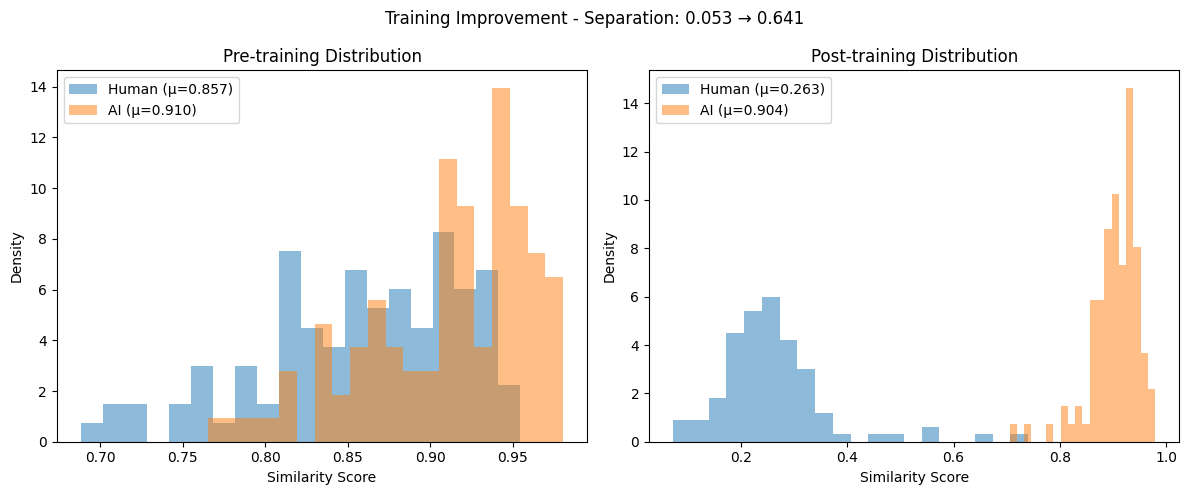


=== Evaluating on Test Set ===
Test set size: 787 human, 787 AI


Evaluating AI texts: 100%|██████████| 787/787 [00:05<00:00, 133.40it/s]



Results:
Best threshold: 0.698
Accuracy: 0.894
AUC: 0.959

Classification Report:
              precision    recall  f1-score   support

       Human      0.881     0.911     0.896       787
          AI      0.908     0.877     0.892       787

    accuracy                          0.894      1574
   macro avg      0.894     0.894     0.894      1574
weighted avg      0.894     0.894     0.894      1574



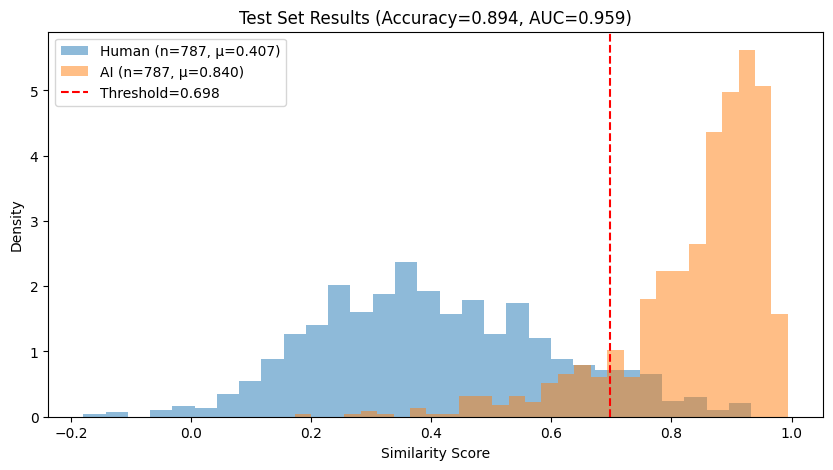


=== Training Complete ===
Model saved to: ./models/paraphrase-MiniLM-L6-v2-ai-detector-fast
Final separation: 0.641
Test accuracy: 0.894


In [8]:
import os
import pickle
import numpy as np
from typing import Dict, List, Tuple
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm

class FastAIDetectorTrainer:
    """Fast trainer using preprocessed revised texts"""
    
    def __init__(self, preprocessed_data_path: str = "./preprocessed_data/combined_dataset.pkl"):
        self.preprocessed_data_path = preprocessed_data_path
        self.preprocessed_data = None
        
    def load_preprocessed_data(self) -> Dict:
        """Load preprocessed data"""
        print("Loading preprocessed data...")
        with open(self.preprocessed_data_path, 'rb') as f:
            self.preprocessed_data = pickle.load(f)
        
        print(f"Loaded data summary:")
        print(f"- Human texts: {len(self.preprocessed_data['human']['ids'])}")
        print(f"- AI texts: {len(self.preprocessed_data['ai']['ids'])}")
        print(f"- Revision model: {self.preprocessed_data['metadata']['revision_model']}")
        
        return self.preprocessed_data
    
    def check_data_distribution(self):
        """Check the distribution of preprocessed data"""
        if self.preprocessed_data is None:
            self.load_preprocessed_data()
        
        human_data = self.preprocessed_data['human']
        ai_data = self.preprocessed_data['ai']
        
        print("\n=== Data Distribution Check ===")
        print(f"Total human texts: {len(human_data['ids'])}")
        print(f"Total AI texts: {len(ai_data['ids'])}")
        
        # Check sample texts
        print("\nSample texts:")
        if len(human_data['ids']) > 0:
            print(f"\nHuman example 1:")
            print(f"Original: {human_data['original'][0][:100]}...")
            print(f"Revised: {human_data['revised'][0][:100]}...")
        
        if len(ai_data['ids']) > 0:
            print(f"\nAI example 1:")
            print(f"Original: {ai_data['original'][0][:100]}...")
            print(f"Revised: {ai_data['revised'][0][:100]}...")
        
        # Check for potential issues
        if len(human_data['ids']) == 0:
            print("\n⚠️ WARNING: No human texts found!")
        if len(ai_data['ids']) == 0:
            print("\n⚠️ WARNING: No AI texts found!")
        
        # Check train/test split
        train_human = int(len(human_data['ids']) * 0.8)
        test_human = len(human_data['ids']) - train_human
        train_ai = int(len(ai_data['ids']) * 0.8)
        test_ai = len(ai_data['ids']) - train_ai
        
        print(f"\nDefault 80/20 split:")
        print(f"Training: {train_human} human, {train_ai} AI")
        print(f"Testing: {test_human} human, {test_ai} AI")
        
        return {
            'n_human': len(human_data['ids']),
            'n_ai': len(ai_data['ids']),
            'train_human': train_human,
            'train_ai': train_ai,
            'test_human': test_human,
            'test_ai': test_ai
        }
        """Load preprocessed data"""
        print("Loading preprocessed data...")
        with open(self.preprocessed_data_path, 'rb') as f:
            self.preprocessed_data = pickle.load(f)
        
        print(f"Loaded data summary:")
        print(f"- Human texts: {len(self.preprocessed_data['human']['ids'])}")
        print(f"- AI texts: {len(self.preprocessed_data['ai']['ids'])}")
        print(f"- Revision model: {self.preprocessed_data['metadata']['revision_model']}")
        
        return self.preprocessed_data
    
    def create_training_samples(self, num_samples: int = None, 
                              human_label: float = 0.2,
                              ai_label: float = 0.85,
                              train_ratio: float = 0.8) -> List[InputExample]:
        """Create training samples from preprocessed data"""
        if self.preprocessed_data is None:
            self.load_preprocessed_data()
        
        samples = []
        
        # Determine sample sizes
        human_data = self.preprocessed_data['human']
        ai_data = self.preprocessed_data['ai']
        
        # Use only training portion of data (first 80% by default)
        max_human_train = int(len(human_data['ids']) * train_ratio)
        max_ai_train = int(len(ai_data['ids']) * train_ratio)
        
        if num_samples is None:
            n_human = max_human_train
            n_ai = max_ai_train
        else:
            n_human = min(num_samples // 2, max_human_train)
            n_ai = min(num_samples // 2, max_ai_train)
        
        print(f"\nCreating training samples:")
        print(f"- Human samples: {n_human} (label={human_label})")
        print(f"- AI samples: {n_ai} (label={ai_label})")
        print(f"- Reserved for testing: {len(human_data['ids']) - max_human_train} human, {len(ai_data['ids']) - max_ai_train} AI")
        
        # Create human text samples (only from training portion)
        for i in range(n_human):
            samples.append(InputExample(
                texts=[human_data['original'][i], human_data['revised'][i]],
                label=human_label
            ))
        
        # Create AI text samples (only from training portion)
        for i in range(n_ai):
            samples.append(InputExample(
                texts=[ai_data['original'][i], ai_data['revised'][i]],
                label=ai_label
            ))
        
        print(f"Total training samples created: {len(samples)}")
        return samples
    
    def analyze_similarity_distribution(self, model: SentenceTransformer, 
                                      sample_size: int = 200) -> Dict:
        """Analyze similarity distribution without API calls"""
        print("\n=== Analyzing Similarity Distribution ===")
        
        human_sims = []
        ai_sims = []
        
        # Sample from preprocessed data
        human_data = self.preprocessed_data['human']
        ai_data = self.preprocessed_data['ai']
        
        # Analyze human texts
        n_human_sample = min(sample_size // 2, len(human_data['ids']))
        for i in range(n_human_sample):
            emb1 = model.encode(human_data['original'][i])
            emb2 = model.encode(human_data['revised'][i])
            sim = util.cos_sim(emb1, emb2).item()
            human_sims.append(sim)
        
        # Analyze AI texts
        n_ai_sample = min(sample_size // 2, len(ai_data['ids']))
        for i in range(n_ai_sample):
            emb1 = model.encode(ai_data['original'][i])
            emb2 = model.encode(ai_data['revised'][i])
            sim = util.cos_sim(emb1, emb2).item()
            ai_sims.append(sim)
        
        print(f"Human texts: μ={np.mean(human_sims):.3f}, σ={np.std(human_sims):.3f}")
        print(f"AI texts: μ={np.mean(ai_sims):.3f}, σ={np.std(ai_sims):.3f}")
        print(f"Separation: {np.mean(ai_sims) - np.mean(human_sims):.3f}")
        
        return {
            'human_sims': human_sims,
            'ai_sims': ai_sims,
            'human_mean': np.mean(human_sims),
            'ai_mean': np.mean(ai_sims),
            'separation': np.mean(ai_sims) - np.mean(human_sims)
        }
    
    def train_model(self, base_model: str = "all-MiniLM-L6-v2",
                   epochs: int = 3,
                   batch_size: int = 16,
                   num_samples: int = None,
                   test_ratio: float = 0.2) -> Tuple[SentenceTransformer, Dict]:
        """Train model using preprocessed data - FAST!"""
        print(f"\n=== Fast Training with Preprocessed Data ===")
        print(f"Base model: {base_model}")
        print(f"Epochs: {epochs}")
        print(f"Batch size: {batch_size}")
        
        # 1. Create training samples (no API calls!)
        all_samples = self.create_training_samples(
            num_samples=num_samples,
            train_ratio=1-test_ratio  # Ensure we only use training portion
        )
        
        # 2. Split train/eval
        train_samples, eval_samples = train_test_split(
            all_samples, test_size=0.15, random_state=42
        )
        
        # 3. Initialize model
        model = SentenceTransformer(base_model)
        
        # 4. Analyze pre-training distribution
        print("\nPre-training analysis:")
        pre_stats = self.analyze_similarity_distribution(model)
        
        # 5. Setup training
        train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=batch_size)
        train_loss = losses.CosineSimilarityLoss(model)
        
        evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
            eval_samples, name="ai-detection-eval"
        )
        
        # 6. Train
        output_path = f"./models/{base_model}-ai-detector-fast"
        
        model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            evaluator=evaluator,
            epochs=epochs,
            warmup_steps=100,
            output_path=output_path,
            save_best_model=True,
            show_progress_bar=True
        )
        
        # 7. Load best model
        best_model = SentenceTransformer(output_path)
        
        # 8. Analyze post-training distribution
        print("\nPost-training analysis:")
        post_stats = self.analyze_similarity_distribution(best_model)
        
        # 9. Visualize improvement
        self._plot_training_improvement(pre_stats, post_stats)
        
        return best_model, {
            'pre_training': pre_stats,
            'post_training': post_stats,
            'model_path': output_path
        }
    
    def evaluate_on_test_set(self, model: SentenceTransformer, 
                           test_ratio: float = 0.2) -> Dict:
        """Evaluate model on test set using preprocessed data"""
        print("\n=== Evaluating on Test Set ===")
        
        similarities = []
        true_labels = []
        
        human_data = self.preprocessed_data['human']
        ai_data = self.preprocessed_data['ai']
        
        # Calculate test indices separately for human and AI texts
        n_human = len(human_data['ids'])
        n_ai = len(ai_data['ids'])
        
        # Split indices for human texts
        human_test_start = int(n_human * (1 - test_ratio))
        human_test_indices = list(range(human_test_start, n_human))
        
        # Split indices for AI texts
        ai_test_start = int(n_ai * (1 - test_ratio))
        ai_test_indices = list(range(ai_test_start, n_ai))
        
        print(f"Test set size: {len(human_test_indices)} human, {len(ai_test_indices)} AI")
        
        # Evaluate human texts
        for idx in tqdm(human_test_indices, desc="Evaluating human texts"):
            emb1 = model.encode(human_data['original'][idx])
            emb2 = model.encode(human_data['revised'][idx])
            sim = util.cos_sim(emb1, emb2).item()
            similarities.append(sim)
            true_labels.append(0)
        
        # Evaluate AI texts
        for idx in tqdm(ai_test_indices, desc="Evaluating AI texts"):
            emb1 = model.encode(ai_data['original'][idx])
            emb2 = model.encode(ai_data['revised'][idx])
            sim = util.cos_sim(emb1, emb2).item()
            similarities.append(sim)
            true_labels.append(1)
        
        # Calculate metrics
        similarities = np.array(similarities)
        true_labels = np.array(true_labels)
        
        fpr, tpr, thresholds = roc_curve(true_labels, similarities)
        best_idx = np.argmax(tpr - fpr)
        best_threshold = thresholds[best_idx]
        
        predictions = (similarities >= best_threshold).astype(int)
        accuracy = np.mean(predictions == true_labels)
        auc = roc_auc_score(true_labels, similarities)
        
        print(f"\nResults:")
        print(f"Best threshold: {best_threshold:.3f}")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"AUC: {auc:.3f}")
        
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions, 
                                  target_names=["Human", "AI"], digits=3))
        
        # Plot test results
        human_scores = similarities[true_labels == 0]
        ai_scores = similarities[true_labels == 1]
        
        plt.figure(figsize=(10, 5))
        plt.hist(human_scores, bins=30, alpha=0.5, density=True,
                label=f'Human (n={len(human_scores)}, μ={np.mean(human_scores):.3f})')
        plt.hist(ai_scores, bins=30, alpha=0.5, density=True,
                label=f'AI (n={len(ai_scores)}, μ={np.mean(ai_scores):.3f})')
        plt.axvline(best_threshold, color='red', linestyle='--', 
                   label=f'Threshold={best_threshold:.3f}')
        plt.xlabel('Similarity Score')
        plt.ylabel('Density')
        plt.title(f'Test Set Results (Accuracy={accuracy:.3f}, AUC={auc:.3f})')
        plt.legend()
        plt.show()
        
        return {
            'threshold': best_threshold,
            'accuracy': accuracy,
            'auc': auc,
            'similarities': similarities,
            'labels': true_labels,
            'predictions': predictions,
            'human_scores': human_scores,
            'ai_scores': ai_scores
        }
    
    def _plot_training_improvement(self, pre_stats: Dict, post_stats: Dict):
        """Visualize training improvement"""
        plt.figure(figsize=(12, 5))
        
        # Pre-training distribution
        plt.subplot(1, 2, 1)
        plt.hist(pre_stats['human_sims'], bins=20, alpha=0.5, 
                label=f"Human (μ={pre_stats['human_mean']:.3f})", density=True)
        plt.hist(pre_stats['ai_sims'], bins=20, alpha=0.5,
                label=f"AI (μ={pre_stats['ai_mean']:.3f})", density=True)
        plt.xlabel('Similarity Score')
        plt.ylabel('Density')
        plt.title('Pre-training Distribution')
        plt.legend()
        
        # Post-training distribution
        plt.subplot(1, 2, 2)
        plt.hist(post_stats['human_sims'], bins=20, alpha=0.5,
                label=f"Human (μ={post_stats['human_mean']:.3f})", density=True)
        plt.hist(post_stats['ai_sims'], bins=20, alpha=0.5,
                label=f"AI (μ={post_stats['ai_mean']:.3f})", density=True)
        plt.xlabel('Similarity Score')
        plt.ylabel('Density')
        plt.title('Post-training Distribution')
        plt.legend()
        
        plt.suptitle(f"Training Improvement - Separation: "
                    f"{pre_stats['separation']:.3f} → {post_stats['separation']:.3f}")
        plt.tight_layout()
        plt.show()

# Quick start script
def quick_train_and_evaluate():
    """Complete training pipeline using preprocessed data"""
    
    # 1. Initialize trainer
    trainer = FastAIDetectorTrainer("./preprocessed_data/combined_dataset.pkl")
    
    # 2. Load preprocessed data
    trainer.load_preprocessed_data()
    
    # 3. Check data distribution
    data_stats = trainer.check_data_distribution()
    
    # Verify we have enough data
    if data_stats['test_human'] == 0 or data_stats['test_ai'] == 0:
        print("\n❌ ERROR: Not enough data for train/test split!")
        print("Please preprocess more data before training.")
        return None, None
    
    # 4. Train model (FAST - no API calls!)
    model, training_stats = trainer.train_model(
        base_model="paraphrase-MiniLM-L6-v2",
        epochs=15,
        batch_size=16,
        num_samples=2000  # Use 2000 samples for training
    )
    
    # 5. Evaluate on test set (last 20% of each category)
    eval_results = trainer.evaluate_on_test_set(model, test_ratio=0.2)
    
    print("\n=== Training Complete ===")
    print(f"Model saved to: {training_stats['model_path']}")
    print(f"Final separation: {training_stats['post_training']['separation']:.3f}")
    print(f"Test accuracy: {eval_results['accuracy']:.3f}")
    
    return model, eval_results

if __name__ == "__main__":
    # Example usage
    print("Fast AI Detector Training")
    print("=" * 50)
    print("\nThis script uses preprocessed data for fast training.")
    print("Make sure you have run the preprocessing script first!")
    print("\nTo start training, call: quick_train_and_evaluate()")
    
    # Uncomment to run:
    model, results = quick_train_and_evaluate()

def diagnose_preprocessed_data(data_path: str = "./preprocessed_data/combined_dataset.pkl"):
    """Standalone function to check preprocessed data"""
    print("=== Diagnosing Preprocessed Data ===")
    
    if not os.path.exists(data_path):
        print(f"❌ ERROR: File not found: {data_path}")
        print("Please run the preprocessing script first!")
        return
    
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    
    print(f"\nMetadata:")
    for key, value in data['metadata'].items():
        print(f"  {key}: {value}")
    
    print(f"\nData counts:")
    print(f"  Human texts: {len(data['human']['ids'])}")
    print(f"  AI texts: {len(data['ai']['ids'])}")
    
    if len(data['human']['ids']) > 0:
        print(f"\nFirst human text:")
        print(f"  ID: {data['human']['ids'][0]}")
        print(f"  Original: {data['human']['original'][0][:150]}...")
        print(f"  Revised: {data['human']['revised'][0][:150]}...")
    
    if len(data['ai']['ids']) > 0:
        print(f"\nFirst AI text:")
        print(f"  ID: {data['ai']['ids'][0]}")
        print(f"  Original: {data['ai']['original'][0][:150]}...")
        print(f"  Revised: {data['ai']['revised'][0][:150]}...")
    
    return data

In [17]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

def evaluate_and_plot_results(model_path: str, 
                              data_path: str = "./preprocessed_data/combined_dataset.pkl", 
                              test_ratio: float = 0.2):
    """
    加载已保存的模型，一次性地在测试集上进行评估，
    并并排绘制ROC曲线和混淆矩阵。

    Args:
        model_path (str): 已保存的微调后模型的路径。
        data_path (str): 预处理数据（.pkl文件）的路径。
        test_ratio (float): 用于测试的数据比例，必须与训练时一致。
    """
    print("--- Generating Full Model Evaluation Report ---")
    
    # 1. 加载模型和数据
    if not os.path.exists(model_path) or not os.path.exists(data_path):
        print(f"❌ ERROR: Model or data file not found.")
        return

    print(f"Loading model from: {model_path}")
    model = SentenceTransformer(model_path)

    print(f"Loading data from: {data_path}")
    with open(data_path, 'rb') as f:
        preprocessed_data = pickle.load(f)

    # 2. 准备测试集并计算相似度分数 (这一部分只用运行一次)
    print("Running inference on the test set...")
    similarities = []
    true_labels = []
    
    human_data = preprocessed_data['human']
    ai_data = preprocessed_data['ai']
    
    human_test_start = int(len(human_data['ids']) * (1 - test_ratio))
    human_test_indices = list(range(human_test_start, len(human_data['ids'])))
    
    ai_test_start = int(len(ai_data['ids']) * (1 - test_ratio))
    ai_test_indices = list(range(ai_test_start, len(ai_data['ids'])))
    
    for idx in tqdm(human_test_indices, desc="Evaluating human test set"):
        emb1 = model.encode(human_data['original'][idx])
        emb2 = model.encode(human_data['revised'][idx])
        similarities.append(util.cos_sim(emb1, emb2).item())
        true_labels.append(0)
    
    for idx in tqdm(ai_test_indices, desc="Evaluating AI test set"):
        emb1 = model.encode(ai_data['original'][idx])
        emb2 = model.encode(ai_data['revised'][idx])
        similarities.append(util.cos_sim(emb1, emb2).item())
        true_labels.append(1)

    # 3. 基于分数，计算所有需要的指标
    print("Calculating metrics...")
    # ROC 指标
    fpr, tpr, thresholds = roc_curve(true_labels, similarities)
    auc_score = roc_auc_score(true_labels, similarities)
    
    # 混淆矩阵指标
    best_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_idx]
    predictions = (np.array(similarities) >= best_threshold).astype(int)
    cm = confusion_matrix(true_labels, predictions)
    
    print(f"\nBest Threshold: {best_threshold:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    # 4. 绘制合并的图表
    # 创建一个1行2列的图床
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # --- 左图: ROC曲线 ---
  

    ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',  label='Chance (AUC = 0.5)')
    ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    
    # --- 右图: 混淆矩阵 ---
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[1],
                xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
    ax[1].set_title('Confusion Matrix')
    ax[1].set_xlabel('Predicted Label')
    ax[1].set_ylabel('True Label')
    
    # 显示整个图床
    plt.tight_layout()
    plt.show()

--- Generating Full Model Evaluation Report ---
Loading model from: ./models/paraphrase-MiniLM-L6-v2-ai-detector-fast
Loading data from: ./preprocessed_data/combined_dataset.pkl
Running inference on the test set...


Evaluating AI test set: 100%|██████████| 1967/1967 [00:14<00:00, 136.16it/s]


Calculating metrics...

Best Threshold: 0.6990
AUC Score: 0.9613


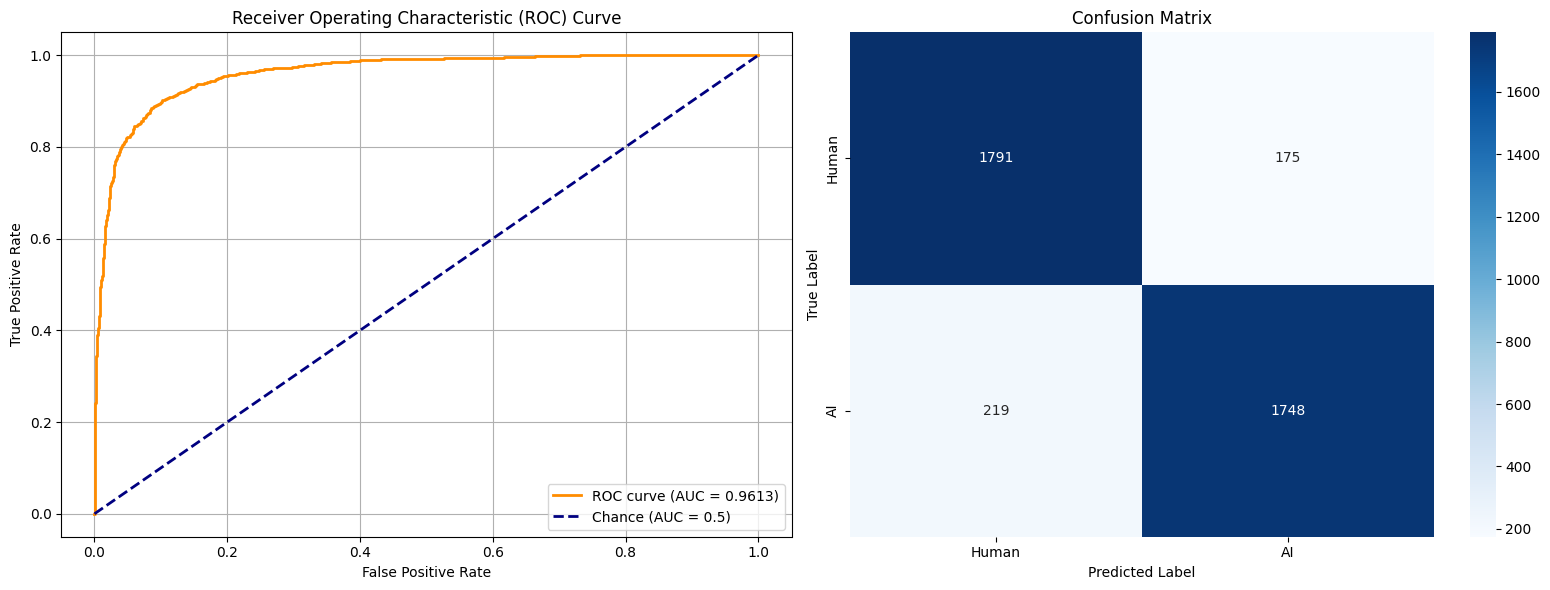

In [18]:

SAVED_MODEL_PATH = "./models/paraphrase-MiniLM-L6-v2-ai-detector-fast" 
PREPROCESSED_DATA_PATH = "./preprocessed_data/combined_dataset.pkl"

evaluate_and_plot_results(model_path=SAVED_MODEL_PATH, data_path=PREPROCESSED_DATA_PATH,test_ratio=0.5)

